In [70]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

## Packages

In [96]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pylab
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import sklearn
import yfinance
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
sns.set()

## Loading the data

In [72]:
raw_data = yfinance.download(tickers= "^GSPC ^FTSE ^N225 ^GDAXI", start= "1994-01-07", end= "2019-09-01",
                            interval= "1d", group_by='ticker', auto_adjust=True, treads=True)
df_comp = raw_data.copy()
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

df_comp = df_comp.iloc[1:]
del df_comp['^N225'],df_comp['^GSPC'],df_comp['^GDAXI'],df_comp['^FTSE']
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

[*********************100%***********************]  4 of 4 completed


## Creating Returns

In [73]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the data

In [74]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
df.shape, df_test.shape

((5352, 12), (1339, 12))

## Fitting a Model 

In [75]:
model_ar = ARIMA(df.ftse, order=(1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [76]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-08,1963.709961,9772.669922,6738.500000,15314.410156,-0.704880,-1.245695,-1.346653,-0.422839,-61.680354,794.952349,-59866.246313,-23.991315
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,40.639543,194.142222,16162.615912,-4.356898
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,-36.148835,433.166778,-67565.994483,-31.953776
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,12.871270,-170.245033,3318.342727,-19.549802
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,42.383382,-533.213704,53656.603796,49.681837


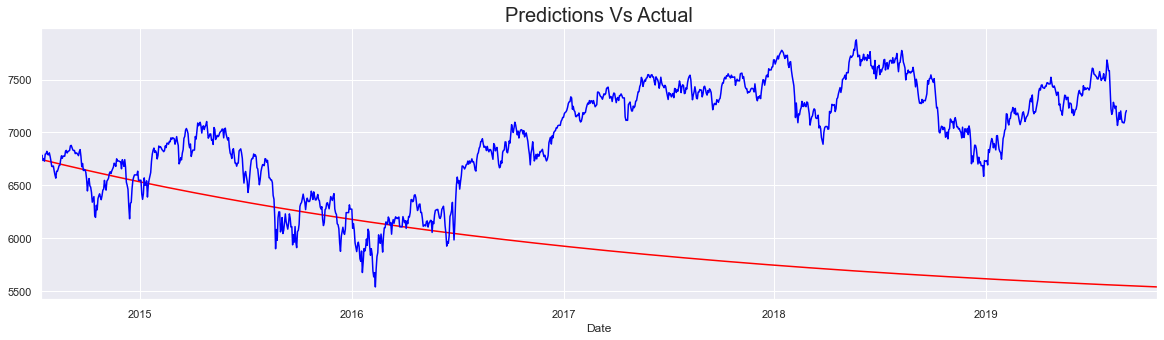

In [83]:
start_date = "2014-07-15"
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end= end_date)
df_pred[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual", size=20); #Poor Predictions are the result of poor model choice
# This poor performance is because of the non-stationary data

## Using Returns instead

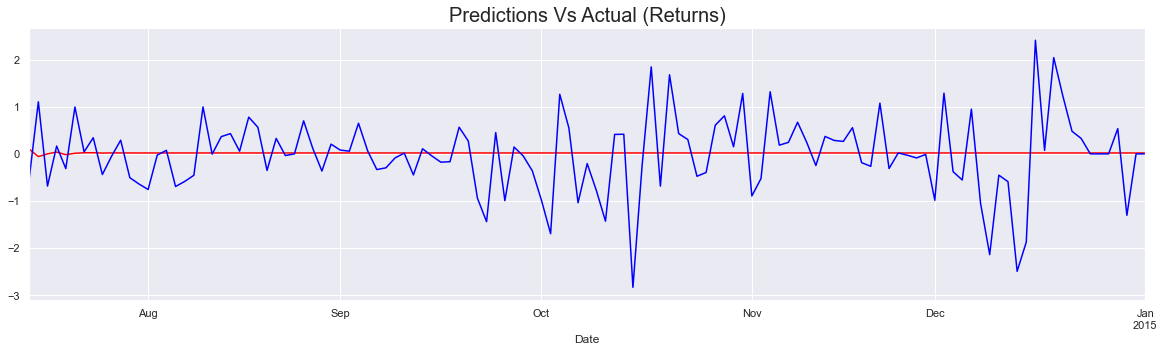

In [84]:
end_date = "2015-01-01"
model_ret_ar = ARIMA(df.ret_ftse[1:], order=(5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end= end_date)

df_pred_ar[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual (Returns)", size=20);
#It does not give much prediction, just tells that the Returns are close to zero or some time zero 

In [28]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 0)   Log Likelihood               -8344.626
Method:                       css-mle   S.D. of innovations              1.151
Date:                Sun, 22 Aug 2021   AIC                          16695.252
Time:                        18:52:29   BIC                          16715.007
Sample:                    01-10-1994   HQIC                         16702.152
                         - 07-14-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.015      1.247      0.212      -0.011       0.049
ar.L1.ret_ftse    -0.0230      0.014     -1.686      0.092      -0.050       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.3965           +0.0000j           43.3965            0.5000
-----------------------------------------------------------------------------
"""

## MA Model

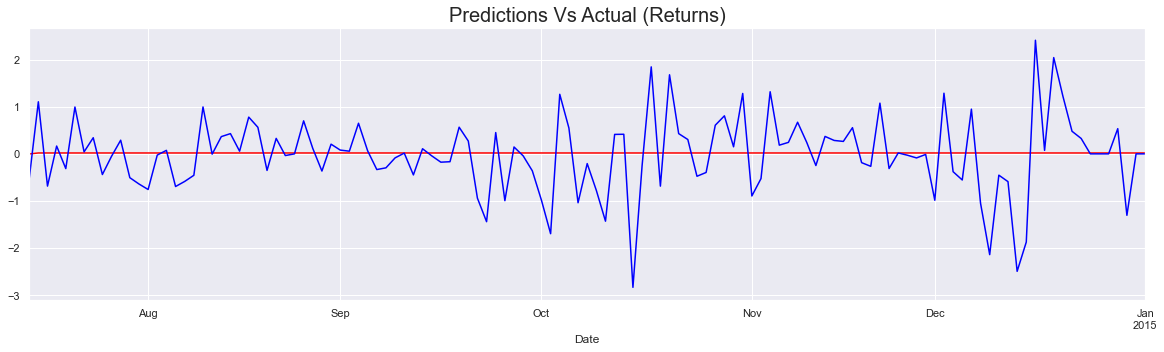

In [36]:
end_date = "2015-01-01"
model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end= end_date)

df_pred_ma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual (Returns)", size=20);

In [37]:
df_pred_ma.head() #all the values after the first are not changing

2014-07-15   -0.001945
2014-07-16    0.019181
2014-07-17    0.019181
2014-07-18    0.019181
2014-07-21    0.019181
Freq: B, dtype: float64

## ARMA Model

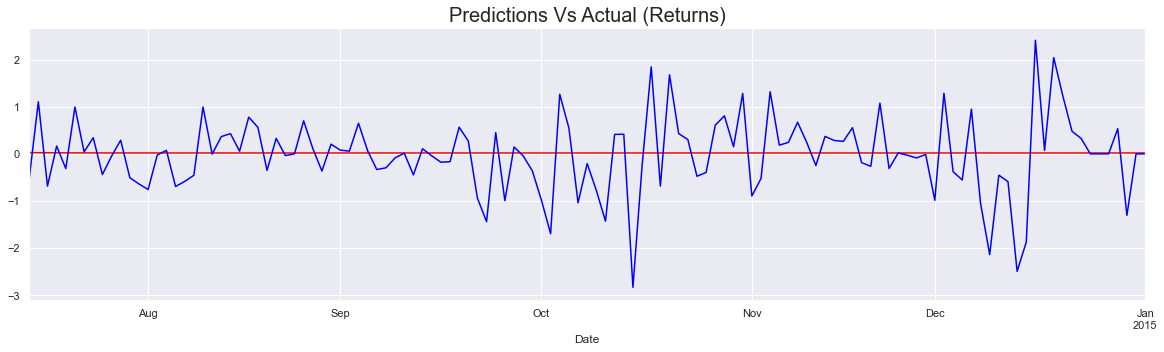

In [45]:
end_date = "2015-01-01"
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end= end_date)

df_pred_arma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual (Returns)", size=20);

In [40]:
df_pred_arma.head() #decreases very slowly

2014-07-15    0.026788
2014-07-16    0.025054
2014-07-17    0.023718
2014-07-18    0.022688
2014-07-21    0.021894
Freq: B, dtype: float64

In [42]:
df_pred_arma.tail() #Flattens out eventually

2014-12-26    0.019223
2014-12-29    0.019223
2014-12-30    0.019223
2014-12-31    0.019223
2015-01-01    0.019223
Freq: B, dtype: float64

## ARMAX Model

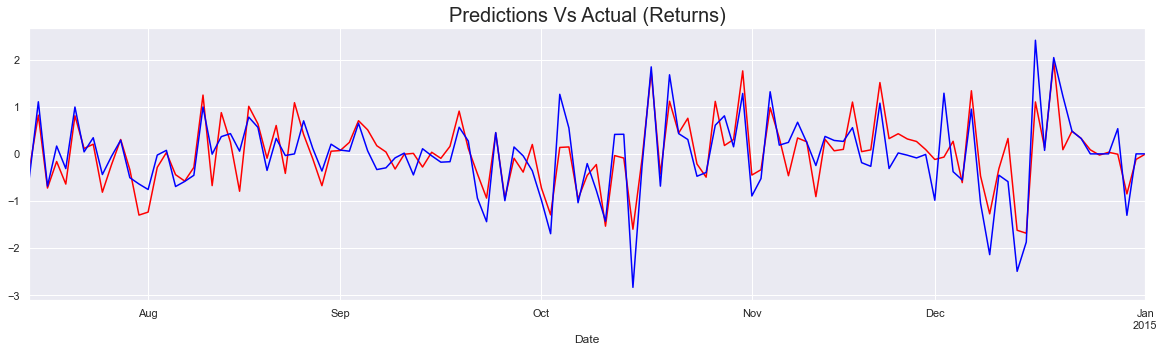

In [47]:
end_date = "2015-01-01"
model_ret_armax = ARIMA(df.ret_ftse[1:], exog= df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order=(0,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end= end_date,
                                        exog = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_armax[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual (Returns)", size=20);
#including outside values like market indexes, improved the model performance dramatically
#but these values are only available in the validation set, it won't be available in the new dataset to be predicted

## SARMA

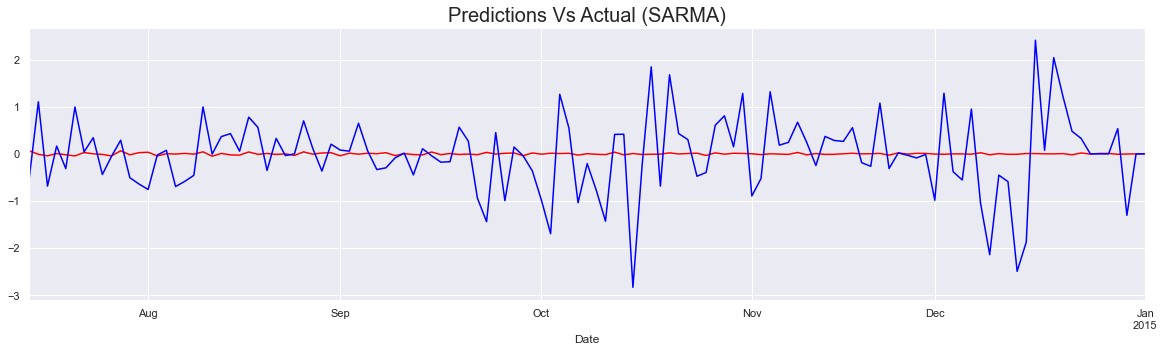

In [52]:
end_date = "2015-01-01"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order= (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end= end_date)

df_pred_sarma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual (SARMA)", size=20);

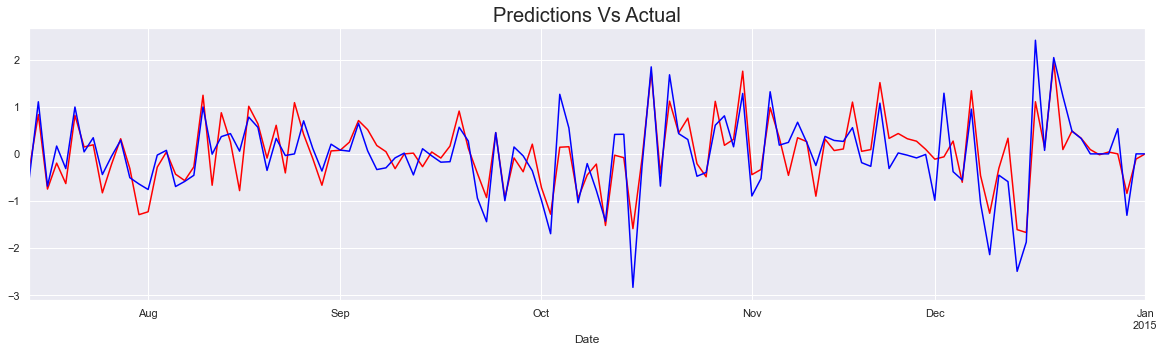

In [53]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog= df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                          order= (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end= end_date,
                                         exog = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_sarimax[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual", size=20);

## Auto ARIMA

In [54]:
model_auto = auto_arima(df.ret_ftse[1:])

In [55]:
model_auto

ARIMA(order=(4, 0, 5), scoring_args={}, suppress_warnings=True)

In [58]:
df_auto_pred =  pd.DataFrame(model_auto.predict(n_periods= len(df_test[start_date:end_date])),
                            index = df_test[start_date:end_date].index)
df_auto_pred

,0
Date,
2014-07-15,0.115380
2014-07-16,-0.038970
2014-07-17,-0.029443
2014-07-18,0.042394
2014-07-21,0.004695
...,...
2014-12-26,0.020278
2014-12-29,0.020155
2014-12-30,0.020239


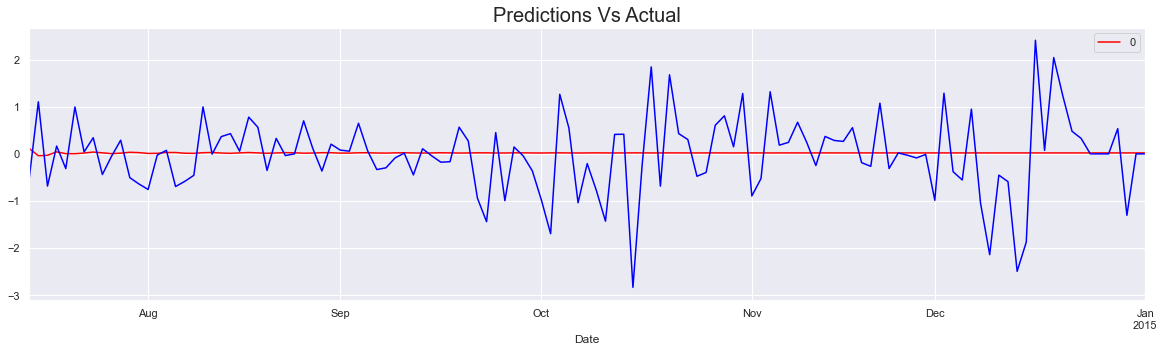

In [60]:
df_auto_pred.plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual", size=20); #These are the results from default model 
#Now we would tune the hyperparameter

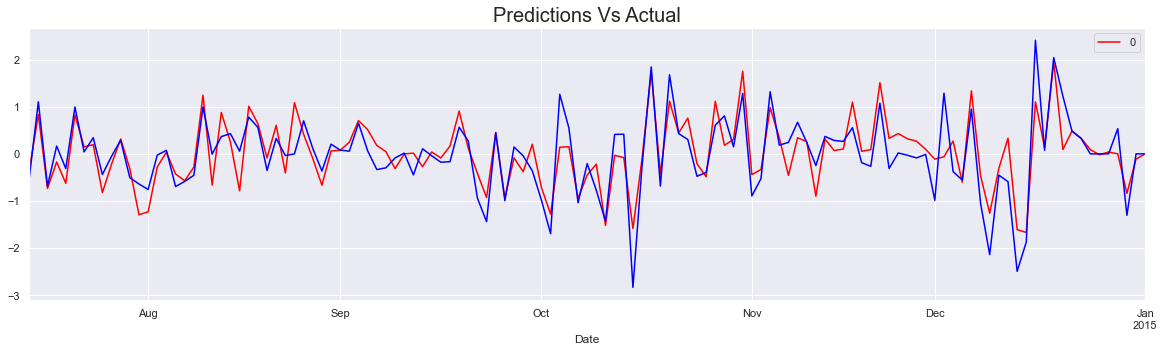

In [62]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m=5, max_p=5,
                        max_q=5, max_P=5, max_Q=5)
df_auto_pred =  pd.DataFrame(model_auto.predict(n_periods= len(df_test[start_date:end_date]),
                                                exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)
df_auto_pred.plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions Vs Actual", size=20);

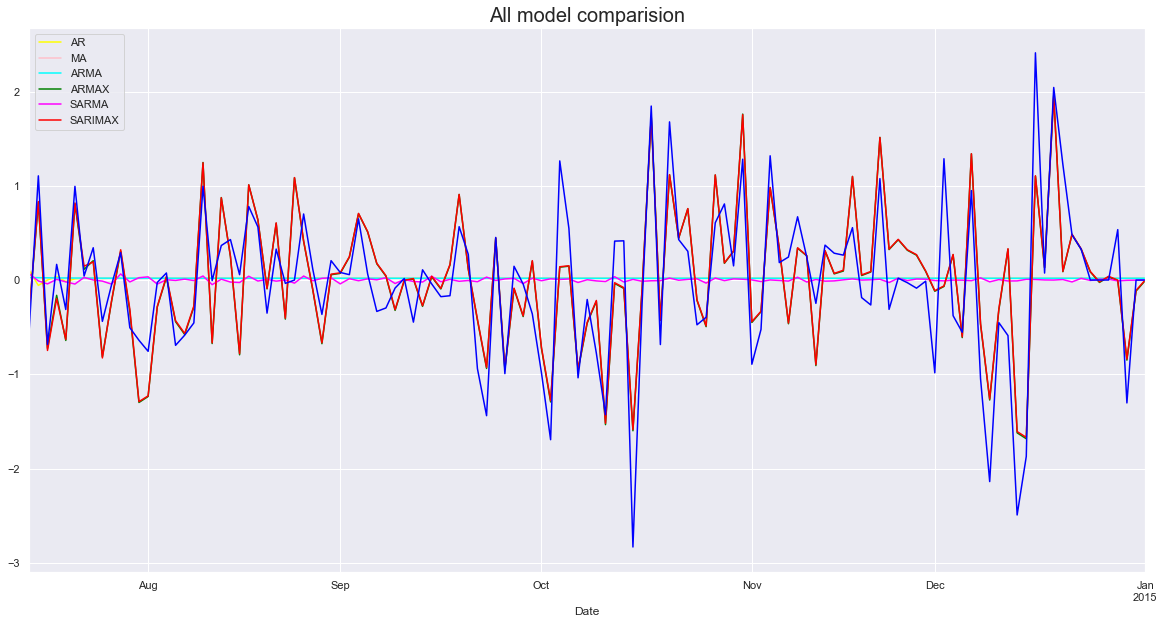

In [69]:
end_date = '2015-01-01'
df_pred_ar[start_date:end_date].plot(figsize=(20,10), color = 'yellow')
df_pred_ma[start_date:end_date].plot(color = 'pink')
df_pred_arma[start_date:end_date].plot(color = 'cyan')
df_pred_armax[start_date:end_date].plot(color = 'green')
df_pred_sarma[start_date:end_date].plot(color = 'magenta')
df_pred_sarimax[start_date:end_date].plot(color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.legend(['AR', 'MA','ARMA', 'ARMAX', 'SARMA','SARIMAX'])
plt.title("All model comparision", size=20);

## Forecasting Volatility

In [85]:
model_garch = arch_model(df_comp.ret_ftse[1:], vol="GARCH", p=1, q=1, mean='Constant', dist='Normal')
results_garch = model_garch.fit(last_obs=start_date, update_freq = 10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 7310.971075984373
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7310.970363582805
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


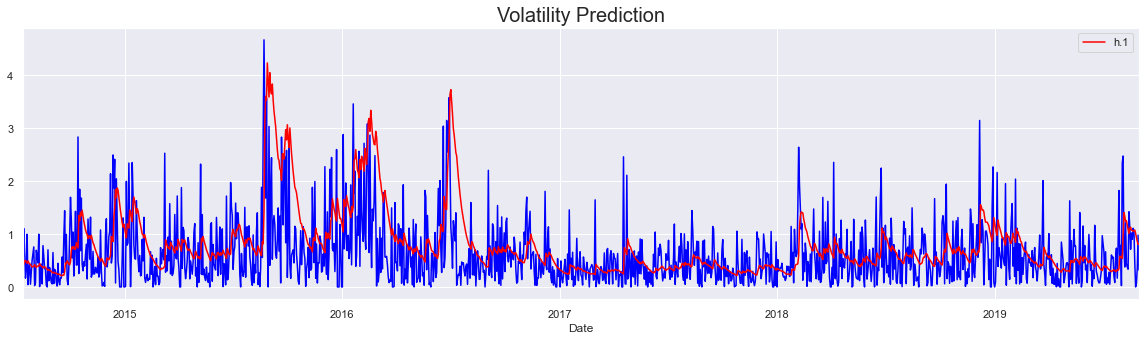

In [93]:
pred_garch = results_garch.forecast(horizon=1, align = 'target')
pred_garch.residual_variance[start_date:].plot(figsize=(20,5), color='red', zorder=2)
df_test.ret_ftse.abs().plot(color='blue', zorder=1)
plt.title("Volatility Prediction", size=20);

In [94]:
pred_garch = results_garch.forecast(horizon= 100, align='target') #so garch could be solution when we don't have exogeneous variables
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811557,0.805781,0.867415,0.940839,1.021018,1.08532,1.074388,1.068147,1.081584,1.09103,...,0.838338,0.839944,0.831341,0.816512,0.828155,0.840395,0.851712,0.865233,0.872802,0.887278


## Multivariate Regression Model

In [99]:
df_ret = df[['ret_spx', 'ret_dax','ret_ftse', 'ret_nikkei']][1:]
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Aug, 2021
Time:                     00:12:47
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.331645
Nobs:                     5346.00    HQIC:                  0.264327
Log likelihood:          -30868.5    FPE:                    1.25633
AIC:                     0.228191    Det(Omega_mle):         1.23678
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039147         0.016160            2.422           0.015
L1.ret_spx           -0.110595         0.017558           -6.299           0.000
L1.ret_dax            0.065376         0.019032           

In [102]:
lag_order_ret = results_var_ret.k_ar
lag_order_ret

5

Text(0.5, 1.0, 'Actual Vs Predicted')

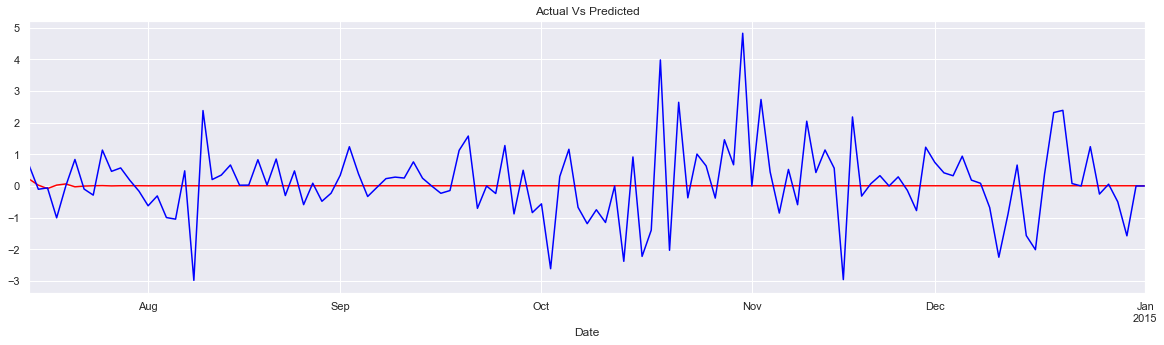

In [107]:
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))
df_ret_pred = pd.DataFrame(data=var_pred_ret, index=df_test[start_date:end_date].index,
                                columns=df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_nikkei[start_date:end_date].plot(color='blue')
plt.title("Actual Vs Predicted")

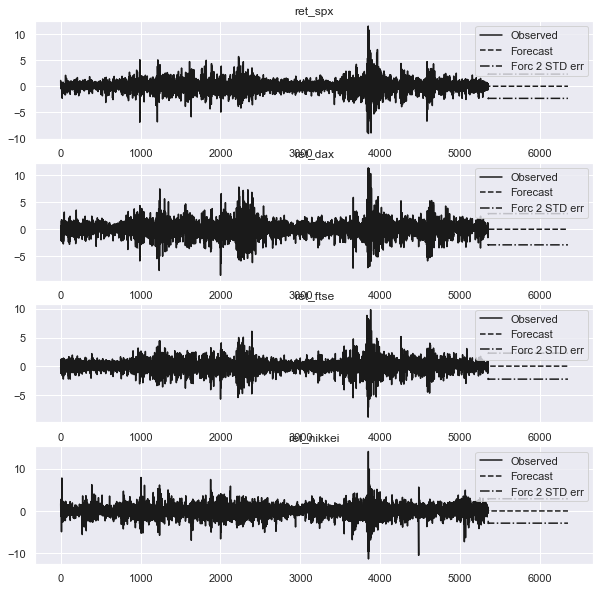

In [111]:
results_var_ret.plot_forecast(1000); #can get an interval depicting the 2 std away from the forecast
# That way we get the 95% range of every market index # A great idea to check the longterm stability in market